In [9]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from tqdm import tqdm
import datetime
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import spacy
from nltk.corpus import wordnet
from ruwordnet import RuWordNet
import requests
from bs4 import BeautifulSoup
from string import punctuation

In [2]:
data = pd.read_csv("Results/NamedEntities.csv",encoding="utf-16")
data = data.drop("Unnamed: 0",axis=1)
data["Datetime"] = pd.to_datetime(data["Datetime"])
nlp = spacy.load("ru_core_news_md")

## Matching pipeline

In [28]:
def overlap_coeff(nes1,nes2):
    nes1 = set(nes1)
    nes2 = set(nes2)
    overlap = nes1 & nes2
    return len(overlap) / max([len(nes1),len(nes2)]) if  max([len(nes1),len(nes2)]) > 0 else 0
 
def event_matching_pipeline(date, timespan, keyword, dataset_a, dataset_b):
    subset_a = dataset_a[(dataset_a.Datetime > date - datetime.timedelta(days=2)) & (dataset_a.Datetime < date + datetime.timedelta(days=2))]
    subset_a = subset_a[~subset_a.Text.isnull()]
    subset_a = subset_a[subset_a.Text.str.contains(keyword, case=False)]

    subset_b = dataset_b[(dataset_b.Datetime > date - datetime.timedelta(days=2)) & (dataset_b.Datetime < date + datetime.timedelta(days=2))]
    subset_b = subset_b[~subset_b.Text.isnull()] 
    subset_b = subset_b[subset_b.Text.str.contains(keyword, case=False)]
 
    sentence_matching_scores = []
    for sent_a in tqdm(subset_a.Text.values):
        sent_a_keywords = []
        doc_a = nlp(sent_a)
        for token_a in doc_a:
            if token_a.pos_ in ['PROPN']:
                sent_a_keywords.append(token_a.lemma_)
 
        for sent_b in subset_b.Text.values:
            sentence_matching_scores.append([])
            doc_b = nlp(sent_b)
            sent_b_keywords = []
            for token_b in doc_b:
                if token_b.pos_ in ['PROPN']:
                    sent_b_keywords.append(token_b.lemma_)
            sentence_matching_scores[-1].append([sent_a, sent_b, sent_a_keywords, sent_b_keywords, overlap_coeff(sent_a_keywords, sent_b_keywords)])
 
    return sentence_matching_scores


def get_pair(matching_results):
    top_score = 0
    a_sent = None
    b_sent = None
    for i in range(len(matching_results)):
        if results[i][0][-1] > top_score:
            top_score = results[i][0][-1]
            a_sent = results[i][0][0]
            b_sent = results[i][0][1]
    return a_sent, b_sent

## Word2Vec models training

In [15]:
data_rus = data.loc[data["Country"] == "Russia"]
data_ukr = data.loc[data["Country"] == "Ukraine"]

In [16]:
# Preparing texts
def preprocess(data):
    texts = []
    for i,row in tqdm(data.iterrows()):
        text = row["Text"]
        if type(text) == float:
            continue
        tokenized = word_tokenize(text)
        texts.append(tokenized)
    return texts

In [17]:
# Preprocess
texts_rus = preprocess(data_rus)
texts_ukr = preprocess(data_ukr)

73861it [00:38, 1922.61it/s]
146543it [01:11, 2048.33it/s]


In [18]:
# Trainig models
model_rus = Word2Vec(sentences=texts_rus, vector_size=100, window=5, min_count=1, workers=4)
model_ukr = Word2Vec(sentences=texts_ukr, vector_size=100, window=5, min_count=1, workers=4)

## Mean vectors

In [19]:
def getMeanVector(sent,model):
    vecs = []
    for word in word_tokenize(sent):
        vecs.append(model.wv[word])
    return np.mean(np.array(vecs),axis=0)


def get_pair_vectors(a_sent, b_sent):
    global model_ukr, model_rus
    sent_a_vec = getMeanVector(a_sent,model_ukr)
    sent_b_vec = getMeanVector(b_sent,model_rus)

    return sent_a_vec, sent_b_vec





## Antonyms

In [20]:
def get_antonyms_from_parser(word):
    URL = "https://sinonim.org/a/"+word
    headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/104.0.0.0 Safari/537.36"}
    page = requests.get(URL,headers=headers)
    soup = BeautifulSoup(page.content, "html.parser")
    result = []
    i = 1
    while True:
        try:
            result.append(soup.find(id="as"+str(i)).text)
            i += 1
        except:
            break

    return result

def get_antonyms_score(sent_a,sent_b):
    score = 0
    words_a = word_tokenize(sent_a)
    words_b = word_tokenize(sent_b)
    
    for word_a in tqdm(words_a):
        if word_a in punctuation:
            continue
        if word_a.isdigit():
            continue
        antonyms = get_antonyms_from_parser(word_a)
        for antonym in antonyms:
            if antonym in words_b:
                score += 1

    return score

In [23]:
# Example
print(get_antonyms_from_parser("быстрый"))

[]


## Main flow

In [29]:
# Testing set
keywords = ["Буча"]
dates = [[2022, 4, 2, 0, 0]]

date = datetime.datetime(2022, 4, 2, 0, 0)
timespan = 2
dataset_a = data_ukr
dataset_b = data_rus

pairs_result = []

for i in range(len(keywords)):
    print("Topic number",i+1)
    keyword = keywords[i]
    date = dates[i]
    date = datetime.datetime(date[0], date[1], date[2], date[3], date[4])
    print("Matching events..")
    matching_results = event_matching_pipeline(date, timespan, keyword, dataset_a, dataset_b)
    a_sent, b_sent = get_pair(matching_results)
    print("Getting vectors..")
    a_vec, b_vec = get_pair_vectors(a_sent, b_sent)
    print("Antonyms score..")
    antonyms_score = get_antonyms_score(a_sent,b_sent)
    pairs_result.append([a_sent,b_sent,a_vec,b_vec,antonyms_score])

Topic number 1
Matching events..


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [01:22<00:00,  1.02s/it]


Getting vectors..
Antonyms score..


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:03<00:00, 15.51it/s]


#### Vectors visualization

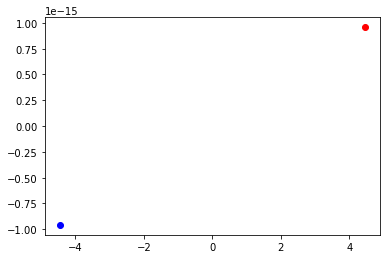

In [33]:
a_vecs = []
b_vecs = []
for i in range(len(pairs_result)):
    a_vecs.append(pairs_result[i][2])
    b_vecs.append(pairs_result[i][3])
    
X = a_vecs + b_vecs
pca = PCA(n_components=2)
pca.fit(X)
a_transformed_vecs = pca.transform(a_vecs)
b_transformed_vecs = pca.transform(b_vecs)

x,y = a_transformed_vecs.T
plt.scatter(x,y,c="red")

x,y = b_transformed_vecs.T
plt.scatter(x,y,c="blue")
plt.show()